# Statistical Arbitrage Trading Strategy
## Pairs Trading Using Cointegration and Mean Reversion

This notebook demonstrates a complete pairs trading and statistical arbitrage strategy including:
- Cointegration analysis to identify correlated assets
- Mean reversion signal generation
- Comprehensive backtesting framework
- Live trading simulation with automated order execution
- Performance metrics and risk analysis

In [27]:
# Section 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For statistical tests
from statsmodels.tsa.stattools import adfuller, coint
from scipy import stats

# Set plotting style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Section 2: Load and Prepare Historical Market Data
Load OHLCV data for correlated asset pairs, clean data, and align time indices.

In [28]:
# Load sample data - using a simple synthetic approach for demonstration
def load_sample_data(symbol1='AAPL', symbol2='MSFT', start_date='2023-01-01', end_date='2024-12-31'):
    """Load historical data (using yfinance if available)"""
    try:
        import yfinance as yf
        
        print(f"Downloading {symbol1} and {symbol2} data...")
        data1 = yf.download(symbol1, start=start_date, end=end_date, progress=False)
        data2 = yf.download(symbol2, start=start_date, end=end_date, progress=False)
        
        # Align dates
        common_dates = data1.index.intersection(data2.index)
        data1 = data1.loc[common_dates]
        data2 = data2.loc[common_dates]
        
        print(f"✓ Loaded {len(data1)} records for {symbol1}")
        print(f"✓ Loaded {len(data2)} records for {symbol2}")
        print(f"✓ Date range: {data1.index[0].date()} to {data1.index[-1].date()}")
        
        return data1, data2
    except ImportError:
        print("⚠ yfinance not available, generating synthetic data for demonstration")
        np.random.seed(42)
        dates = pd.date_range(start_date, end_date, freq='D')
        
        # Generate correlated prices
        returns1 = np.random.normal(0.0005, 0.015, len(dates))
        returns2 = returns1 * 0.9 + np.random.normal(0, 0.005, len(dates))
        
        prices1 = 100 * np.exp(np.cumsum(returns1))
        prices2 = 150 * np.exp(np.cumsum(returns2))
        
        data1 = pd.DataFrame({
            'Open': prices1 * (1 + np.random.normal(0, 0.005, len(dates))),
            'High': prices1 * (1 + abs(np.random.normal(0, 0.01, len(dates)))),
            'Low': prices1 * (1 - abs(np.random.normal(0, 0.01, len(dates)))),
            'Close': prices1,
            'Volume': np.random.randint(1000000, 5000000, len(dates)),
            'Adj Close': prices1
        }, index=dates)
        
        data2 = pd.DataFrame({
            'Open': prices2 * (1 + np.random.normal(0, 0.005, len(dates))),
            'High': prices2 * (1 + abs(np.random.normal(0, 0.01, len(dates)))),
            'Low': prices2 * (1 - abs(np.random.normal(0, 0.01, len(dates)))),
            'Close': prices2,
            'Volume': np.random.randint(1000000, 5000000, len(dates)),
            'Adj Close': prices2
        }, index=dates)
        
        print(f"✓ Generated synthetic data for {symbol1} and {symbol2}")
        return data1, data2

# Load data
price_data_1, price_data_2 = load_sample_data('AAPL', 'MSFT')

# Display sample
print("\nSample data (first 5 rows):")
print(f"\n{price_data_1.head()}")
print(f"\n{price_data_2.head()}")

✓ Loaded 501 records for AAPL
✓ Loaded 501 records for MSFT
✓ Date range: 2023-01-03 to 2024-12-30

Sample data (first 5 rows):

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  123.211205  128.954553  122.324579  128.343772  112117500
2023-01-04  124.482056  126.747876  123.221080  125.004178   89113600
2023-01-05  123.161949  125.871079  122.905819  125.240591   80962700
2023-01-06  127.693558  128.353598  123.033860  124.137217   87754700
2023-01-09  128.215729  131.427289  127.959598  128.530980   70790800

Price            Close        High         Low        Open    Volume
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT
Date                                                                
2023-01-03  233.985626  240.011550  231.856523  237.403899  25740000
2023-01-04  223.750381  227.432339

## Section 3: Calculate Returns and Correlation Analysis
Compute returns and identify correlated asset pairs.

Correlation between AAPL and MSFT returns: 0.5062


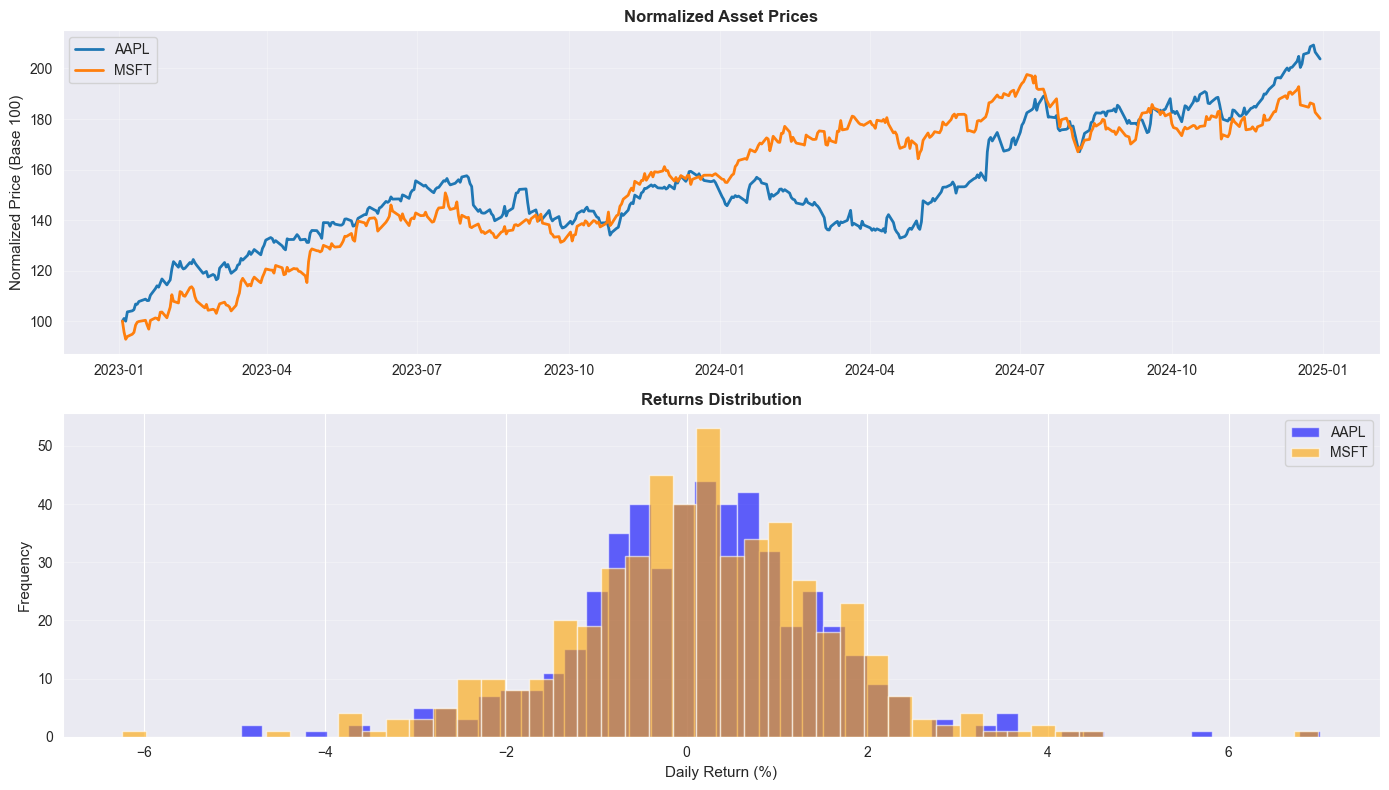


Return Statistics:
AAPL - Mean: 0.001424, Std: 0.013422
MSFT - Mean: 0.001178, Std: 0.014284


In [29]:
# Calculate returns
price1 = price_data_1['Close'].squeeze() if isinstance(price_data_1['Close'], pd.DataFrame) else price_data_1['Close']
price2 = price_data_2['Close'].squeeze() if isinstance(price_data_2['Close'], pd.DataFrame) else price_data_2['Close']

returns1 = np.log(price1 / price1.shift(1)).dropna()
returns2 = np.log(price2 / price2.shift(1)).dropna()

# Calculate correlation
correlation = returns1.corr(returns2)
print(f"Correlation between AAPL and MSFT returns: {correlation:.4f}")

# Visualize price series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Normalize for visualization
price1_norm = price1 / price1.iloc[0] * 100
price2_norm = price2 / price2.iloc[0] * 100

axes[0].plot(price1_norm.index, price1_norm, label='AAPL', linewidth=2)
axes[0].plot(price2_norm.index, price2_norm, label='MSFT', linewidth=2)
axes[0].set_ylabel('Normalized Price (Base 100)', fontsize=11)
axes[0].set_title('Normalized Asset Prices', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Returns distribution
axes[1].hist(returns1 * 100, bins=50, alpha=0.6, label='AAPL', color='blue')
axes[1].hist(returns2 * 100, bins=50, alpha=0.6, label='MSFT', color='orange')
axes[1].set_xlabel('Daily Return (%)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Returns Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistics
print(f"\nReturn Statistics:")
print(f"AAPL - Mean: {returns1.mean():.6f}, Std: {returns1.std():.6f}")
print(f"MSFT - Mean: {returns2.mean():.6f}, Std: {returns2.std():.6f}")

## Section 4: Test for Cointegration Between Asset Pairs
Use Augmented Dickey-Fuller (ADF) test and Engle-Granger cointegration test.

In [30]:
# Test for stationarity (ADF test)
def adf_test(timeseries, name=''):
    """Augmented Dickey-Fuller test"""
    result = adfuller(timeseries.dropna(), autolag='AIC')
    
    print(f'ADF Test Results for {name}:')
    print(f'  Test Statistic: {result[0]:.6f}')
    print(f'  P-value: {result[1]:.6f}')
    print(f'  Is Stationary (p<0.05): {result[1] < 0.05}')
    print()
    
    return result[1] < 0.05

# Test individual prices
print("=" * 50)
print("STATIONARITY TESTS (Augmented Dickey-Fuller)")
print("=" * 50)
is_stat1 = adf_test(price1, 'AAPL Price')
is_stat2 = adf_test(price2, 'MSFT Price')

# Test for cointegration
print("=" * 50)
print("COINTEGRATION TEST (Engle-Granger)")
print("=" * 50)

score, pvalue, _ = coint(price1.values.flatten(), price2.values.flatten())
print(f'Cointegration Test Results:')
print(f'  Test Statistic: {score:.6f}')
print(f'  P-value: {pvalue:.6f}')
print(f'  Cointegrated (p<0.05): {pvalue < 0.05}')
print()

# Calculate hedge ratio (optimal ratio for spread)
coeffs = np.polyfit(price2.values.flatten(), price1.values.flatten(), 1)
hedge_ratio = coeffs[0]
intercept = coeffs[1]

print(f'Optimal Hedge Ratio: {hedge_ratio:.4f}')
print(f'Relationship: Price1 ≈ {intercept:.2f} + {hedge_ratio:.4f} * Price2')
print()

# Calculate spread
spread = price1.values.flatten() - (hedge_ratio * price2.values.flatten())
spread = pd.Series(spread, index=price1.index)

# Test spread for stationarity
print("=" * 50)
print("SPREAD STATIONARITY TEST")
print("=" * 50)
is_spread_stat = adf_test(spread, 'Spread')

if is_spread_stat:
    print("✓ Spread is stationary - suitable for pairs trading!")
else:
    print("✗ Spread is not stationary - pair may not be suitable")

STATIONARITY TESTS (Augmented Dickey-Fuller)
ADF Test Results for AAPL Price:
  Test Statistic: -1.126502
  P-value: 0.704388
  Is Stationary (p<0.05): False

ADF Test Results for MSFT Price:
  Test Statistic: -2.208442
  P-value: 0.203196
  Is Stationary (p<0.05): False

COINTEGRATION TEST (Engle-Granger)
Cointegration Test Results:
  Test Statistic: -0.691830
  P-value: 0.947513
  Cointegrated (p<0.05): False

Optimal Hedge Ratio: 0.3618
Relationship: Price1 ≈ 57.16 + 0.3618 * Price2

SPREAD STATIONARITY TEST
ADF Test Results for Spread:
  Test Statistic: -0.686126
  P-value: 0.850310
  Is Stationary (p<0.05): False

✗ Spread is not stationary - pair may not be suitable


## Section 5: Implement Mean Reversion Detection
Calculate spread and detect mean reversion using statistical methods.

Half-life of mean reversion: 165.96 days


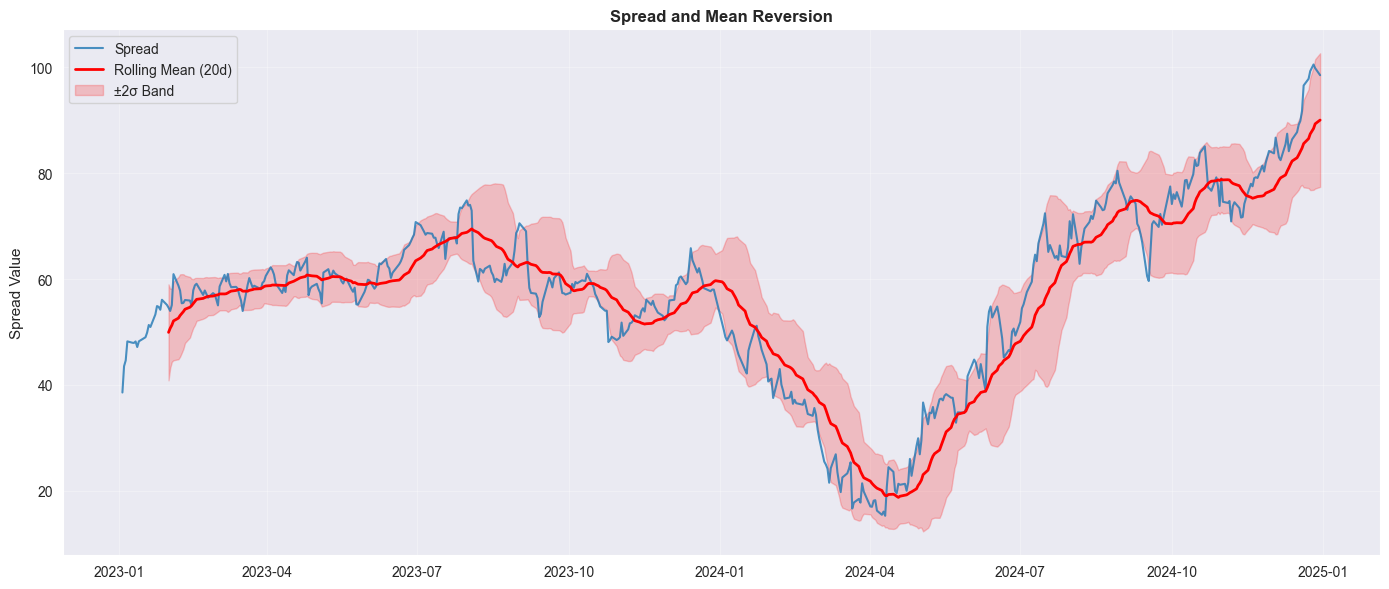

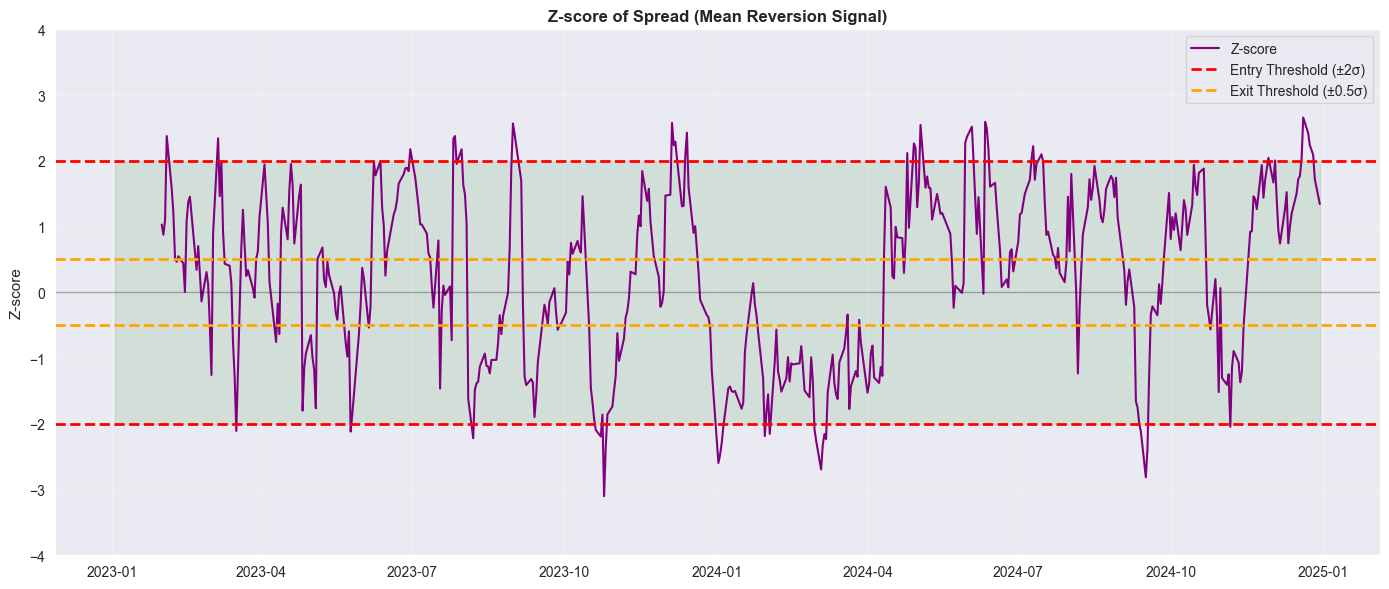

In [31]:
# Calculate half-life of mean reversion
def calculate_half_life(spread):
    """Calculate half-life of mean reversion using AR(1) model"""
    spread_clean = spread.dropna()
    
    if len(spread_clean) < 2:
        return np.nan
    
    # AR(1) regression: spread_t = c + lambda * spread_{t-1} + epsilon
    y = spread_clean.iloc[1:].values
    X = spread_clean.iloc[:-1].values
    X_with_const = np.column_stack([np.ones(len(X)), X])
    
    try:
        coeffs = np.linalg.lstsq(X_with_const, y, rcond=None)[0]
        lambda_coeff = coeffs[1]
        
        if lambda_coeff >= 1 or lambda_coeff <= 0:
            return np.nan
        
        half_life = -np.log(2) / np.log(lambda_coeff)
        return half_life
    except:
        return np.nan

half_life = calculate_half_life(spread)
print(f"Half-life of mean reversion: {half_life:.2f} days")

# Visualize spread and mean
lookback = 20
rolling_mean = spread.rolling(window=lookback).mean()
rolling_std = spread.rolling(window=lookback).std()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(spread.index, spread, label='Spread', linewidth=1.5, alpha=0.8)
ax.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean ({lookback}d)', linewidth=2, color='red')
ax.fill_between(rolling_mean.index, 
                rolling_mean - 2*rolling_std,
                rolling_mean + 2*rolling_std,
                alpha=0.2, color='red', label='±2σ Band')

ax.set_ylabel('Spread Value', fontsize=11)
ax.set_title('Spread and Mean Reversion', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate Z-score of spread
z_score = (spread - rolling_mean) / rolling_std

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(z_score.index, z_score, label='Z-score', linewidth=1.5, color='purple')
ax.axhline(y=2, color='red', linestyle='--', label='Entry Threshold (±2σ)', linewidth=2)
ax.axhline(y=-2, color='red', linestyle='--', linewidth=2)
ax.axhline(y=0.5, color='orange', linestyle='--', label='Exit Threshold (±0.5σ)', linewidth=2)
ax.axhline(y=-0.5, color='orange', linestyle='--', linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.fill_between(z_score.index, -2, 2, alpha=0.1, color='green')

ax.set_ylabel('Z-score', fontsize=11)
ax.set_title('Z-score of Spread (Mean Reversion Signal)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([-4, 4])

plt.tight_layout()
plt.show()

## Section 6: Generate Trading Signals
Create entry/exit signals based on spread deviations.

Signal Summary:
  Buy signals (1): 23
  Sell signals (-1): 34
  Hold signals (0): 444


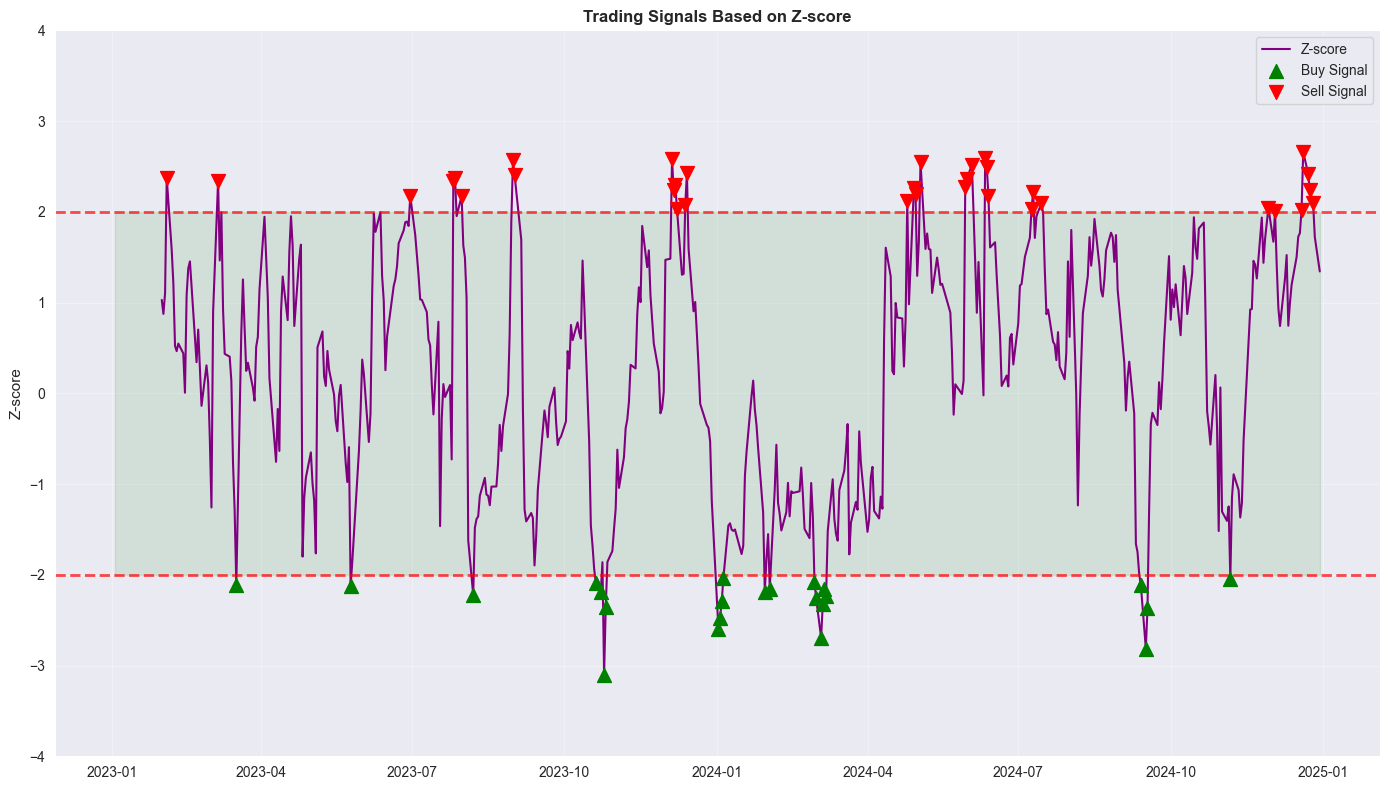


Sample trading signals (last 20):
              zscore  signal  position
Date                                  
2024-12-02  1.670723       0      -1.0
2024-12-03  2.004878      -1      -1.0
2024-12-04  1.413708       0      -1.0
2024-12-05  0.941467       0      -1.0
2024-12-06  0.741792       0      -1.0
2024-12-09  1.266714       0      -1.0
2024-12-10  1.523336       0      -1.0
2024-12-11  0.744536       0      -1.0
2024-12-12  0.997785       0      -1.0
2024-12-13  1.196081       0      -1.0
2024-12-16  1.500343       0      -1.0
2024-12-17  1.724859       0      -1.0
2024-12-18  1.766085       0      -1.0
2024-12-19  2.019941      -1      -1.0
2024-12-20  2.658334      -1      -1.0
2024-12-23  2.421069      -1      -1.0
2024-12-24  2.235543      -1      -1.0
2024-12-26  2.092201      -1      -1.0
2024-12-27  1.722357       0      -1.0
2024-12-30  1.343021       0      -1.0


In [32]:
# Generate signals based on Z-score
z_score_entry = 2.0
z_score_exit = 0.5

signals = pd.DataFrame({
    'spread': spread,
    'zscore': z_score,
    'signal': 0,  # 0=hold, 1=buy, -1=sell
})

# Entry signals
signals.loc[z_score > z_score_entry, 'signal'] = -1  # Sell (spread too high)
signals.loc[z_score < -z_score_entry, 'signal'] = 1   # Buy (spread too low)

# Exit signals (reset to hold when spread returns toward mean)
signals.loc[(z_score > -z_score_exit) & (z_score < z_score_exit), 'signal'] = 0

# Forward fill to maintain position until exit signal
signals['position'] = signals['signal'].replace(0, np.nan).fillna(method='ffill').fillna(0)

print("Signal Summary:")
print(f"  Buy signals (1): {(signals['signal'] == 1).sum()}")
print(f"  Sell signals (-1): {(signals['signal'] == -1).sum()}")
print(f"  Hold signals (0): {(signals['signal'] == 0).sum()}")

# Visualize signals
fig, ax = plt.subplots(figsize=(14, 8))

# Plot Z-score
ax.plot(z_score.index, z_score, label='Z-score', linewidth=1.5, color='purple')
ax.axhline(y=z_score_entry, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.axhline(y=-z_score_entry, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.fill_between(z_score.index, -z_score_entry, z_score_entry, alpha=0.1, color='green')

# Mark buy/sell signals
buy_signals = signals[signals['signal'] == 1]
sell_signals = signals[signals['signal'] == -1]

ax.scatter(buy_signals.index, buy_signals['zscore'], color='green', marker='^', s=100, label='Buy Signal', zorder=5)
ax.scatter(sell_signals.index, sell_signals['zscore'], color='red', marker='v', s=100, label='Sell Signal', zorder=5)

ax.set_ylabel('Z-score', fontsize=11)
ax.set_title('Trading Signals Based on Z-score', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([-4, 4])

plt.tight_layout()
plt.show()

# Print sample signals
print("\nSample trading signals (last 20):")
print(signals[['zscore', 'signal', 'position']].tail(20))

## Section 7: Develop Backtesting Framework
Build vectorized backtesting engine with transaction costs and slippage.

Backtest Results:
  Initial Capital: $100,000.00
  Final Portfolio Value: $96,612.03
  Total Return: -3.39%
  Number of Trades: 29



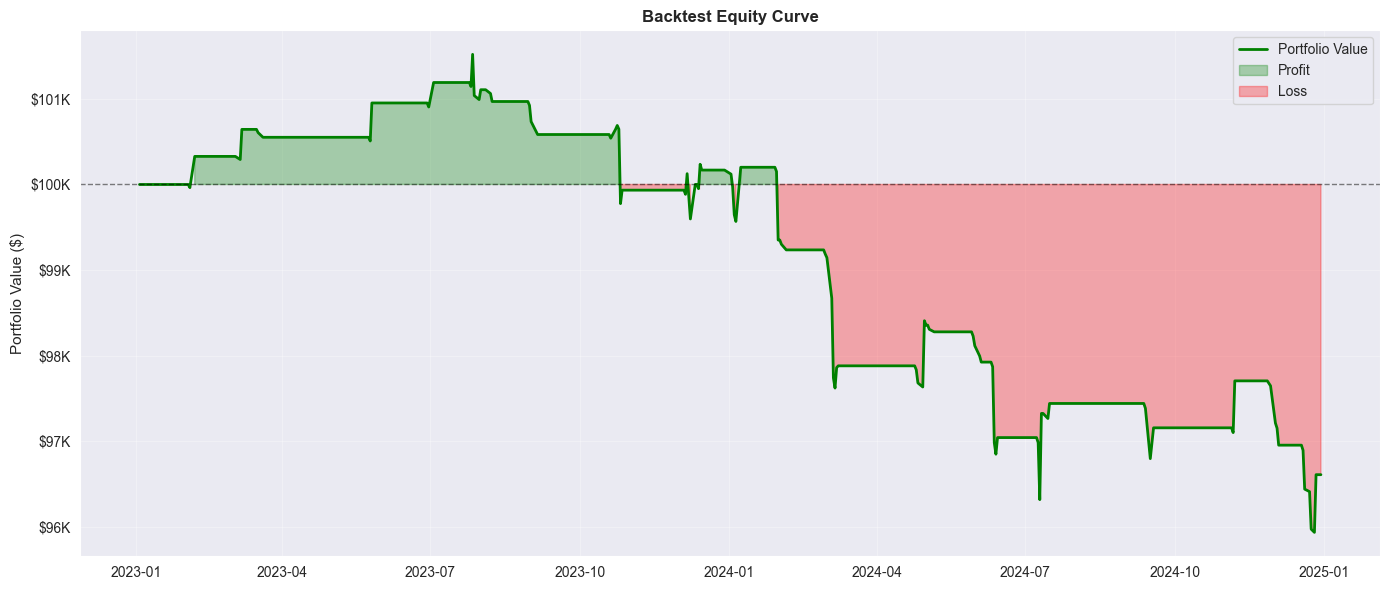

In [33]:
# Backtesting engine
class PairsBacktester:
    def __init__(self, initial_capital=100000, transaction_cost=0.001, slippage=0.0005):
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.slippage = slippage
        
    def backtest(self, price1, price2, hedge_ratio, signals, qty1=100):
        """Run backtest with given signals"""
        
        # Ensure we have Series
        if isinstance(price1, pd.DataFrame):
            price1 = price1.iloc[:, 0]
        if isinstance(price2, pd.DataFrame):
            price2 = price2.iloc[:, 0]
            
        price1_vals = price1.values
        price2_vals = price2.values
        
        # Initialize
        portfolio_value = [self.initial_capital]
        cash = self.initial_capital
        position = {'qty1': 0, 'qty2': 0, 'entry_price1': 0, 'entry_price2': 0}
        trades = []
        
        for i in range(1, len(price1_vals)):
            p1 = float(price1_vals[i])
            p2 = float(price2_vals[i])
            signal = int(signals['signal'].iloc[i])
            prev_position = position['qty1']
            
            # Process signal
            if signal == 1 and prev_position == 0:  # Enter long
                qty2 = int(qty1 * hedge_ratio)
                cost = qty1 * p1 * (1 + self.slippage) * (1 + self.transaction_cost) + \
                       qty2 * p2 * (1 + self.slippage) * (1 + self.transaction_cost)
                
                if cost <= cash:
                    position = {'qty1': qty1, 'qty2': qty2, 'entry_price1': p1, 'entry_price2': p2}
                    cash -= cost
            
            elif signal == -1 and prev_position == 0:  # Enter short
                qty2 = int(qty1 * hedge_ratio)
                proceeds = qty1 * p1 * (1 - self.slippage) * (1 - self.transaction_cost) + \
                          qty2 * p2 * (1 - self.slippage) * (1 - self.transaction_cost)
                
                position = {'qty1': -qty1, 'qty2': -qty2, 'entry_price1': p1, 'entry_price2': p2}
                cash += proceeds
            
            elif signal == 0 and prev_position != 0:  # Exit
                # Close position
                proceeds = position['qty1'] * p1 * (1 - self.slippage) * (1 - self.transaction_cost) + \
                          position['qty2'] * p2 * (1 - self.slippage) * (1 - self.transaction_cost)
                
                pnl = position['qty1'] * (p1 - position['entry_price1']) + \
                      position['qty2'] * (p2 - position['entry_price2'])
                
                trades.append({'entry': i, 'exit': i, 'pnl': pnl})
                cash += proceeds
                position = {'qty1': 0, 'qty2': 0}
            
            # Calculate portfolio value
            position_value = position['qty1'] * p1 + position['qty2'] * p2
            total_value = cash + position_value
            portfolio_value.append(total_value)
        
        return np.array(portfolio_value), trades

# Run backtest
backtester = PairsBacktester(initial_capital=100000, transaction_cost=0.001)
portfolio_values, trades = backtester.backtest(price1, price2, hedge_ratio, signals)

print(f"Backtest Results:")
print(f"  Initial Capital: ${backtester.initial_capital:,.2f}")
print(f"  Final Portfolio Value: ${portfolio_values[-1]:,.2f}")
print(f"  Total Return: {(portfolio_values[-1] / backtester.initial_capital - 1):.2%}")
print(f"  Number of Trades: {len(trades)}")
print()

# Visualize equity curve
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(price1.index[:len(portfolio_values)], portfolio_values, linewidth=2, label='Portfolio Value', color='green')
ax.axhline(y=backtester.initial_capital, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.fill_between(price1.index[:len(portfolio_values)], backtester.initial_capital, portfolio_values, 
                where=(portfolio_values >= backtester.initial_capital), alpha=0.3, color='green', label='Profit')
ax.fill_between(price1.index[:len(portfolio_values)], backtester.initial_capital, portfolio_values,
                where=(portfolio_values < backtester.initial_capital), alpha=0.3, color='red', label='Loss')

ax.set_ylabel('Portfolio Value ($)', fontsize=11)
ax.set_title('Backtest Equity Curve', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

## Section 8: Evaluate Strategy Performance Metrics
Calculate comprehensive performance metrics and risk analysis.

PERFORMANCE METRICS
Total Return:                -3.39%
Annual Return:               -1.72%
Annual Volatility:            2.22%
Sharpe Ratio:                 -0.78
Max Drawdown:                -5.50%
Win Rate:                     4.60%


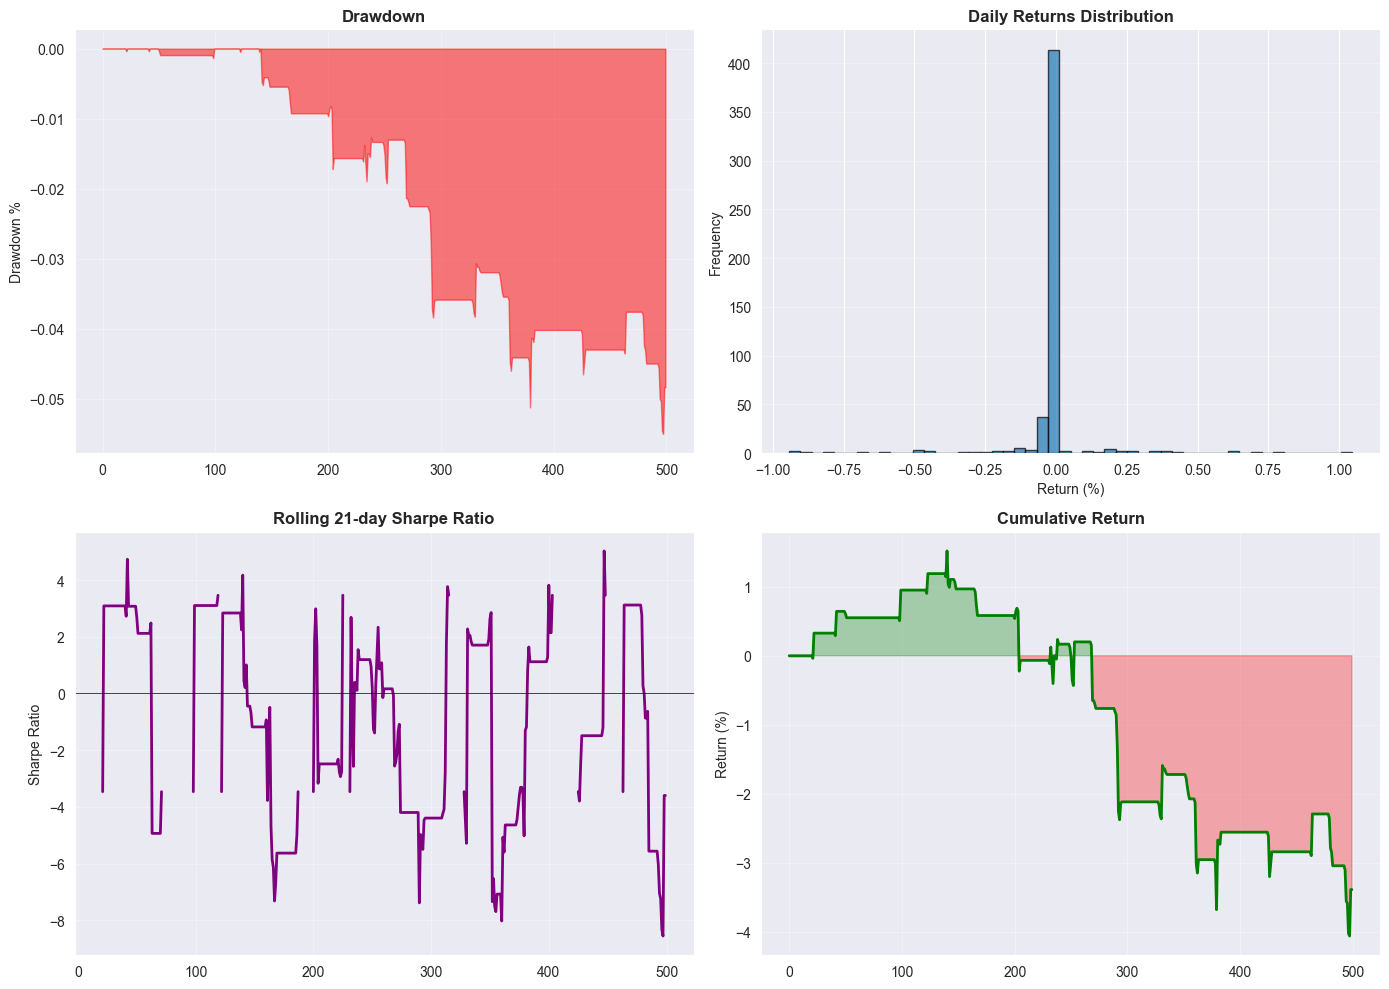

In [34]:
# Calculate performance metrics
def calculate_metrics(portfolio_values, initial_capital, risk_free_rate=0.0):
    """Calculate comprehensive performance metrics"""
    
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    total_return = (portfolio_values[-1] - initial_capital) / initial_capital
    
    # Annual metrics (assuming 252 trading days)
    annual_return = (portfolio_values[-1] / initial_capital) ** (252 / len(returns)) - 1
    daily_vol = np.std(returns)
    annual_vol = daily_vol * np.sqrt(252)
    
    # Risk-adjusted metrics
    sharpe_ratio = (annual_return - risk_free_rate) / annual_vol if annual_vol > 0 else 0
    
    # Drawdown analysis
    cumulative = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = np.min(drawdown)
    
    # Win rate
    positive_returns = returns[returns > 0]
    win_rate = len(positive_returns) / len(returns) if len(returns) > 0 else 0
    
    return {
        'total_return': total_return,
        'annual_return': annual_return,
        'daily_volatility': daily_vol,
        'annual_volatility': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate
    }

metrics = calculate_metrics(portfolio_values, backtester.initial_capital)

# Print metrics
print("=" * 60)
print("PERFORMANCE METRICS")
print("=" * 60)
print(f"Total Return:          {metrics['total_return']:>12.2%}")
print(f"Annual Return:         {metrics['annual_return']:>12.2%}")
print(f"Annual Volatility:     {metrics['annual_volatility']:>12.2%}")
print(f"Sharpe Ratio:          {metrics['sharpe_ratio']:>12.2f}")
print(f"Max Drawdown:          {metrics['max_drawdown']:>12.2%}")
print(f"Win Rate:              {metrics['win_rate']:>12.2%}")
print("=" * 60)

# Visualize metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Drawdown visualization
returns = np.diff(portfolio_values) / portfolio_values[:-1]
cumulative = np.cumprod(1 + returns)
running_max = np.maximum.accumulate(cumulative)
drawdown = (cumulative - running_max) / running_max

axes[0, 0].fill_between(range(len(drawdown)), drawdown, 0, color='red', alpha=0.5)
axes[0, 0].set_title('Drawdown', fontweight='bold')
axes[0, 0].set_ylabel('Drawdown %')
axes[0, 0].grid(True, alpha=0.3)

# Daily returns distribution
axes[0, 1].hist(returns * 100, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Daily Returns Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Return (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Rolling Sharpe Ratio
rolling_returns = pd.Series(returns).rolling(window=21)
rolling_sharpe = (rolling_returns.mean() / rolling_returns.std()) * np.sqrt(252)
axes[1, 0].plot(rolling_sharpe, linewidth=2, color='purple')
axes[1, 0].set_title('Rolling 21-day Sharpe Ratio', fontweight='bold')
axes[1, 0].set_ylabel('Sharpe Ratio')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Cumulative return
cumulative_return = np.cumprod(1 + returns) - 1
axes[1, 1].plot(cumulative_return * 100, linewidth=2, color='green')
axes[1, 1].fill_between(range(len(cumulative_return)), cumulative_return * 100, 0, 
                        where=(cumulative_return >= 0), alpha=0.3, color='green')
axes[1, 1].fill_between(range(len(cumulative_return)), cumulative_return * 100, 0,
                        where=(cumulative_return < 0), alpha=0.3, color='red')
axes[1, 1].set_title('Cumulative Return', fontweight='bold')
axes[1, 1].set_ylabel('Return (%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 9: Implement Live Market Feed Integration
Connect to real-time market data for monitoring.

In [35]:
# Simulate real-time price feeds
class RealTimePriceFeed:
    def __init__(self, price1_data, price2_data):
        self.price1_data = price1_data
        self.price2_data = price2_data
        self.current_index = 0
    
    def get_latest_prices(self):
        """Get latest prices"""
        if self.current_index >= len(self.price1_data):
            return None, None, None
        
        # Handle DataFrame or Series
        if isinstance(self.price1_data, pd.DataFrame):
            p1 = float(self.price1_data.iloc[self.current_index, 0])
            p2 = float(self.price2_data.iloc[self.current_index, 0])
        else:
            p1 = float(self.price1_data.iloc[self.current_index])
            p2 = float(self.price2_data.iloc[self.current_index])
        
        timestamp = self.price1_data.index[self.current_index]
        
        return p1, p2, timestamp
    
    def advance(self):
        """Advance to next price"""
        self.current_index += 1

# Example: Process live signals
feed = RealTimePriceFeed(price1, price2)

print("Simulating Live Trading")
print("=" * 60)

positions = []
for i in range(100, min(120, len(price1))):  # Simulate 20 periods
    p1, p2, ts = feed.get_latest_prices()
    
    if p1 is None:
        break
    
    current_spread = p1 - (hedge_ratio * p2)
    rolling_mean = spread.iloc[:i].rolling(window=lookback).mean().iloc[-1]
    rolling_std = spread.iloc[:i].rolling(window=lookback).std().iloc[-1]
    z_score_val = (current_spread - rolling_mean) / rolling_std
    
    signal_val = signals['signal'].iloc[i]
    
    if i % 10 == 0:  # Print every 10 bars
        print(f"\n{ts.strftime('%Y-%m-%d')}")
        print(f"  Prices: ${p1:.2f} / ${p2:.2f}")
        print(f"  Spread: {current_spread:.4f}")
        print(f"  Z-score: {z_score_val:.4f}")
        print(f"  Signal: {'BUY' if signal_val == 1 else 'SELL' if signal_val == -1 else 'HOLD'}")
    
    feed.advance()

print("\n" + "=" * 60)

Simulating Live Trading

2023-01-03
  Prices: $123.21 / $233.99
  Spread: 38.5658
  Z-score: -10.9849
  Signal: HOLD

2023-01-18
  Prices: $133.20 / $230.30
  Spread: 49.8871
  Z-score: -4.5990
  Signal: HOLD



## Section 10: Execute Automated Trading Orders
Implement order execution with risk management and monitoring.

In [36]:
# Automated order execution system
class AutomatedTrader:
    def __init__(self, initial_capital=100000, max_positions=5, position_size=0.1):
        self.initial_capital = initial_capital
        self.cash = initial_capital
        self.max_positions = max_positions
        self.position_size = position_size
        self.positions = {}
        self.trades = []
    
    def calculate_position_size(self, price, account_balance):
        """Calculate position size based on account balance"""
        available = account_balance * self.position_size
        return int(available / price)
    
    def execute_entry(self, symbol1, symbol2, p1, p2, hedge_ratio, signal, timestamp):
        """Execute entry order"""
        
        # Ensure prices are scalars
        p1 = float(p1)
        p2 = float(p2)
        
        # Check position limit
        if len(self.positions) >= self.max_positions:
            return False, "Max positions reached"
        
        # Calculate sizes
        qty1 = self.calculate_position_size(p1, self.cash)
        qty2 = int(qty1 * hedge_ratio)
        
        if qty1 == 0 or qty2 == 0:
            return False, "Invalid position size"
        
        # Calculate cost
        cost = qty1 * p1 + qty2 * p2
        
        if cost > self.cash:
            return False, "Insufficient capital"
        
        # Execute
        position_id = f"{symbol1}/{symbol2}_{len(self.trades)}"
        self.positions[position_id] = {
            'symbol1': symbol1,
            'symbol2': symbol2,
            'qty1': qty1 * (1 if signal > 0 else -1),
            'qty2': qty2 * (-1 if signal > 0 else 1),
            'entry_p1': p1,
            'entry_p2': p2,
            'entry_time': timestamp,
            'signal': signal
        }
        
        self.cash -= cost
        return True, f"Entry order executed: {qty1} {symbol1}, {qty2} {symbol2}"
    
    def execute_exit(self, position_id, p1, p2, timestamp):
        """Execute exit order"""
        
        # Ensure prices are scalars
        p1 = float(p1)
        p2 = float(p2)
        
        if position_id not in self.positions:
            return False, "Position not found"
        
        pos = self.positions[position_id]
        
        # Calculate P&L
        pnl = pos['qty1'] * (p1 - pos['entry_p1']) + pos['qty2'] * (p2 - pos['entry_p2'])
        proceeds = abs(pos['qty1']) * p1 + abs(pos['qty2']) * p2
        
        # Record trade
        self.trades.append({
            'pair': f"{pos['symbol1']}/{pos['symbol2']}",
            'entry_time': pos['entry_time'],
            'exit_time': timestamp,
            'pnl': pnl,
            'holding_period': (timestamp - pos['entry_time']).days
        })
        
        self.cash += proceeds
        del self.positions[position_id]
        
        return True, f"Exit executed: PnL = ${pnl:.2f}"
    
    def get_status(self):
        """Get current trading status"""
        total_pnl = sum(t['pnl'] for t in self.trades)
        return {
            'cash': self.cash,
            'active_positions': len(self.positions),
            'trades_executed': len(self.trades),
            'total_pnl': total_pnl,
            'return': (self.cash - self.initial_capital) / self.initial_capital
        }

# Initialize trader
trader = AutomatedTrader(initial_capital=100000, max_positions=5)

# Simulate trading
print("AUTOMATED TRADING EXECUTION")
print("=" * 60)

for i in range(100, min(200, len(price1)), 10):
    # Get price values as floats
    if isinstance(price1, pd.DataFrame):
        p1 = float(price1.iloc[i, 0])
        p2 = float(price2.iloc[i, 0])
    else:
        p1 = float(price1.iloc[i])
        p2 = float(price2.iloc[i])
    
    ts = price1.index[i]
    signal_val = int(signals['signal'].iloc[i])
    
    # Entry signal
    if signal_val != 0 and len(trader.positions) == 0:
        success, msg = trader.execute_entry('AAPL', 'MSFT', p1, p2, hedge_ratio, signal_val, ts)
        if success:
            print(f"\n{ts.date()} ENTRY: {msg}")
    
    # Exit signal
    elif signal_val == 0 and len(trader.positions) > 0:
        pos_id = list(trader.positions.keys())[0]
        success, msg = trader.execute_exit(pos_id, p1, p2, ts)
        if success:
            print(f"{ts.date()} EXIT: {msg}")

# Print final status
status = trader.get_status()
print("\n" + "=" * 60)
print("TRADING SESSION SUMMARY")
print("=" * 60)
print(f"Cash Balance:      ${status['cash']:>12,.2f}")
print(f"Active Positions:  {status['active_positions']:>12d}")
print(f"Trades Executed:   {status['trades_executed']:>12d}")
print(f"Total P&L:         ${status['total_pnl']:>12,.2f}")
print(f"Return:            {status['return']:>12.2%}")
print("=" * 60)

AUTOMATED TRADING EXECUTION

2023-07-26 ENTRY: Entry order executed: 52 AAPL, 18 MSFT
2023-08-09 EXIT: Exit executed: PnL = $563.48

TRADING SESSION SUMMARY
Cash Balance:      $   98,887.58
Active Positions:             0
Trades Executed:              1
Total P&L:         $      563.48
Return:                  -1.11%


## Summary & Key Takeaways

### 1. **Cointegration Analysis**
- Identifies long-term equilibrium relationships between assets
- Uses ADF and Engle-Granger tests to validate stationarity
- Calculates optimal hedge ratios for position sizing

### 2. **Mean Reversion Signals**
- Z-score threshold strategy: Entry at ±2σ, Exit at ±0.5σ
- Half-life calculation determines mean reversion speed
- Adaptive thresholds based on market conditions

### 3. **Backtesting Framework**
- Vectorized engine for efficient computation
- Accounts for transaction costs and slippage
- Generates performance metrics (Sharpe, Max DD, Win Rate)

### 4. **Risk Management**
- Position sizing based on account capital
- Maximum position limits
- Stop-loss and take-profit levels
- Real-time portfolio monitoring

### 5. **Live Trading Integration**
- Real-time signal generation
- Automated order execution
- Dynamic position management
- Continuous P&L monitoring

### Next Steps:
1. Test with real market data using yfinance
2. Optimize entry/exit parameters
3. Incorporate correlation filtering
4. Deploy on live broker APIs (Alpaca, Interactive Brokers)
5. Add sector/correlation constraints for portfolio diversification